In [1]:
library(ggplot2)
library(pROC)
library(patchwork)
library(SILGGM)
options(warn=-1)

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var


Loading required package: Rcpp



In [2]:
rm(list = ls())
source('../tools.R')
source('../FLAG.R')

set.seed(1234)

m = 10
pblock = 40
P = m + pblock
N = 200

theta = 0.3
Theta_aa = matrix(c(1, theta, theta, 1), 2, 2)

pi=0.3

ratio = c(1, 0.9, 1, 0.7, 1, 0.5, 1, 0.3, 1, 0.1)
Pre = matrix(0, P, P)

k=0
while(T){
  k=k+1
  # beta:
  delta = 0.2
  Gamma_beta = matrix(delta, m, m)
  diag(Gamma_beta) = 0.8
  
  nonzero = NULL
  for(i in 1:m){
    nonzero = cbind(nonzero, matrix(rbinom((P-2), 1, ratio[i]), nrow = (P-2), ncol=1))
  }
  
  beta = MASS::mvrnorm((P-2), rep(0,m), Gamma_beta) * nonzero
  
  # generate precision
  pair.num=as.integer(m/2)
  for(k in 1:pair.num){
      i=2*k-1
      j=2*k
      Pre[c(i,j), c(i,j)]=Theta_aa
      Theta_ba=-beta[,c(i,j)]%*%Theta_aa
      
      # overlap fixed as zero, only update dim>m
      Pre[(m+1):P, c(i,j)]=Theta_ba[(m-2+1):(P-2),]
      
      # Symmetrization
      Pre[c(i,j), -c(i,j)]=t(Pre[-c(i,j), c(i,j)])
  }
  
  block = matrix(rbinom(pblock*pblock, 1, pi)*runif(pblock*pblock, 3, 5), nrow = pblock, ncol = pblock )
  block[lower.tri(block)]=t(block)[lower.tri(block)]
  diag(block) = 50

  Pre[(m+1):(m+pblock), (m+1):(m+pblock)]=block
  
  values = eigen(Pre)$values
  # check if Pre is positive definite
  if(all(values > 0.001)){
    cat('Succeed.')
    break
  } 
  if(k>1000){
    cat('Failed.')
    break
  }
}


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




Succeed.

In [3]:
## pairs (1,2), (3,4), (5,6), (7,8), (9,10)
# ground truth = theta = 0.3

rep.times = 100
method.num = 9
res12 = matrix(0, rep.times, method.num)
res34 = matrix(0, rep.times, method.num)
res56 = matrix(0, rep.times, method.num)
res78 = matrix(0, rep.times, method.num)
res90 = matrix(0, rep.times, method.num)
err = NULL
err.2hub = NULL
err.1hub = NULL
err.block = NULL
fdr.list = c(0.01, 0.02, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3)
fdr.len = length(fdr.list)
fdr = NULL
fdr.2hub = NULL
fdr.1hub = NULL
fdr.block = NULL
MLE.hub.list = c()
CLIME.hub.list = c()
OM.hub.list = c()
ANT.hub.list = c()
BGGM.hub.list = c()
GLASSO.hub.list = c()
HGL.hub.list = c()
DSGL.hub.list = c()

MLE.2hub.list = c()
CLIME.2hub.list = c()
OM.2hub.list = c()
ANT.2hub.list = c()
BGGM.2hub.list = c()
GLASSO.2hub.list = c()
HGL.2hub.list = c()
DSGL.2hub.list = c()

MLE.block.list = c()
CLIME.block.list = c()
OM.block.list = c()
ANT.block.list = c()
BGGM.block.list = c()
GLASSO.block.list = c()
HGL.block.list = c()
DSGL.block.list = c()

Sigma = solve(Pre)
Pre.adj = get.adj(Pre)
for(rep in 1:rep.times){
  # bggm method will fix the random seed, which makes data generated in iterations are the same
  set.seed(rep)
  
  Z = MASS::mvrnorm(N, rep(0, P), Sigma)
  Z = scale(Z, center = T, scale = F)

  MLE = run.mle(Z)
  CLIME = run.clime(Z)
  OM = OurMethod(Z)
  ANT = run.ant(Z)
  BGGM = run.bggm(Z)
  GLASSO = run.glasso(Z)
  HGL = run.hglasso(Z)
  DSGL = run.dsglasso(Z)
  

  res12[rep, ] = c(drop(Pre[1,2]), drop(MLE[1,2]), drop(CLIME$icov[1,2]),
                   OM$precision.est[1,2], drop(ANT$precision[1,2]), drop(BGGM$prec[1,2]),
                   drop(GLASSO$wi[1,2]),  drop(HGL$Theta[1,2]), drop(DSGL$precision[1,2]))
  res34[rep, ] = c(drop(Pre[3,4]), drop(MLE[3,4]), drop(CLIME$icov[3,4]),
                   OM$precision.est[3,4], drop(ANT$precision[3,4]), drop(BGGM$prec[3,4]),
                   drop(GLASSO$wi[3,4]), drop(HGL$Theta[3,4]), drop(DSGL$precision[3,4]))
  res56[rep, ] = c(drop(Pre[5,6]), drop(MLE[5,6]), drop(CLIME$icov[5,6]),
                   OM$precision.est[5,6], drop(ANT$precision[5,6]), drop(BGGM$prec[5,6]),
                   drop(GLASSO$wi[5,6]), drop(HGL$Theta[5,6]), drop(DSGL$precision[5,6]))
  res78[rep, ] = c(drop(Pre[7,8]), drop(MLE[7,8]), drop(CLIME$icov[7,8]),
                   OM$precision.est[7,8], drop(ANT$precision[7,8]), drop(BGGM$prec[7,8]),
                   drop(GLASSO$wi[7,8]), drop(HGL$Theta[7,8]), drop(DSGL$precision[7,8]))
  res90[rep, ] = c(drop(Pre[9,10]), drop(MLE[9,10]), drop(CLIME$icov[9,10]),
                   OM$precision.est[9,10], drop(ANT$precision[9,10]), drop(BGGM$prec[9,10]),
                   drop(GLASSO$wi[9,10]), drop(HGL$Theta[9,10]), drop(DSGL$precision[9,10]))
  
  true.prec = Pre
  MLE.prec = MLE
  CLIME.prec = CLIME$icov
  OM.prec = OM$precision.est
  ANT.prec = ANT$precision
  BGGM.prec = BGGM$precision
  GLASSO.prec = GLASSO$wi
  HGL.prec = HGL$Theta
  DSGL.prec = DSGL$precision
  
  err0 = data.frame(
    cal.err(MLE.prec, Pre),
    cal.err(CLIME.prec, Pre),
#     cal.err(OM.prec, Pre),
    cal.err(OM.prec* get.fdr(OM$precision.pval, thr=0.1, diag.val=1), Pre),
#     cal.err(ANT.prec, Pre),
    cal.err(ANT.prec* get.fdr(ANT$p_precision, thr=0.1, diag.val=1), Pre),
    cal.err(BGGM.prec, Pre),
    cal.err(GLASSO.prec, Pre),
    cal.err(HGL.prec, Pre),
    cal.err(DSGL.prec, Pre)
  )
  err = rbind(err, err0)
  
  s1=s2=1
  e1=e2=m
  err.2hub0 = data.frame(
    cal.err(MLE.prec, Pre, s1=s1, e1=e1, s2=s2, e2=e2),
    cal.err(CLIME.prec, Pre, s1=s1, e1=e1, s2=s2, e2=e2),
#     cal.err(OM.prec, Pre, s1=s1, e1=e1, s2=s2, e2=e2),
    cal.err(OM.prec* get.fdr(OM$precision.pval, thr=0.1, diag.val=1), Pre, s1=s1, e1=e1, s2=s2, e2=e2),
#     cal.err(ANT.prec, Pre, s1=s1, e1=e1, s2=s2, e2=e2),
    cal.err(ANT.prec* get.fdr(ANT$p_precision, thr=0.1, diag.val=1), Pre, s1=s1, e1=e1, s2=s2, e2=e2),
    cal.err(BGGM.prec, Pre, s1=s1, e1=e1, s2=s2, e2=e2),
    cal.err(GLASSO.prec, Pre, s1=s1, e1=e1, s2=s2, e2=e2),
    cal.err(HGL.prec, Pre, s1=s1, e1=e1, s2=s2, e2=e2),
    cal.err(DSGL.prec, Pre, s1=s1, e1=e1, s2=s2, e2=e2)
  )
  err.2hub = rbind(err.2hub, err.2hub0)
  
  s1=1
  e1=m
  s2=(m+1)
  e2=P
  err.1hub0 = data.frame(
    cal.err(MLE.prec, Pre, s1=s1, e1=e1, s2=s2, e2=e2),
    cal.err(CLIME.prec, Pre, s1=s1, e1=e1, s2=s2, e2=e2),
#     cal.err(OM.prec, Pre, s1=s1, e1=e1, s2=s2, e2=e2),
    cal.err(OM.prec* get.fdr(OM$precision.pval, thr=0.1, diag.val=1), Pre, s1=s1, e1=e1, s2=s2, e2=e2),
#     cal.err(ANT.prec, Pre, s1=s1, e1=e1, s2=s2, e2=e2),
    cal.err(ANT.prec* get.fdr(ANT$p_precision, thr=0.1, diag.val=1), Pre, s1=s1, e1=e1, s2=s2, e2=e2),
    cal.err(BGGM.prec, Pre, s1=s1, e1=e1, s2=s2, e2=e2),
    cal.err(GLASSO.prec, Pre, s1=s1, e1=e1, s2=s2, e2=e2),
    cal.err(HGL.prec, Pre, s1=s1, e1=e1, s2=s2, e2=e2),
    cal.err(DSGL.prec, Pre, s1=s1, e1=e1, s2=s2, e2=e2)
  )
  err.1hub = rbind(err.1hub, err.1hub0)
  
  s1=s2=(m+1)
  e1=e2=P
  err.block0 = data.frame(
    cal.err(MLE.prec, Pre, s1=s1, e1=e1, s2=s2, e2=e2),
    cal.err(CLIME.prec, Pre, s1=s1, e1=e1, s2=s2, e2=e2),
#     cal.err(OM.prec, Pre, s1=s1, e1=e1, s2=s2, e2=e2),
    cal.err(OM.prec* get.fdr(OM$precision.pval, thr=0.1, diag.val=1), Pre, s1=s1, e1=e1, s2=s2, e2=e2),
#     cal.err(ANT.prec, Pre, s1=s1, e1=e1, s2=s2, e2=e2),
    cal.err(ANT.prec* get.fdr(ANT$p_precision, thr=0.1, diag.val=1), Pre, s1=s1, e1=e1, s2=s2, e2=e2),
    cal.err(BGGM.prec, Pre, s1=s1, e1=e1, s2=s2, e2=e2),
    cal.err(GLASSO.prec, Pre, s1=s1, e1=e1, s2=s2, e2=e2),
    cal.err(HGL.prec, Pre, s1=s1, e1=e1, s2=s2, e2=e2),
    cal.err(DSGL.prec, Pre, s1=s1, e1=e1, s2=s2, e2=e2)
  )
  err.block = rbind(err.block, err.block0)
  
  fdr.om = c()
  fdr.ant = c()
  fdr.gfc = c()
  fdr.2hub.om = c()
  fdr.2hub.ant = c()
  fdr.2hub.gfc = c()
  fdr.1hub.om = c()
  fdr.1hub.ant = c()
  fdr.1hub.gfc = c()
  fdr.block.om = c()
  fdr.block.ant = c()
  fdr.block.gfc = c()
  gfc = SILGGM(Z, method='GFC_L', alpha=fdr.list, ndelta=10, global=TRUE)
  for(fdr.idx in 1:fdr.len){
    fdr.thr = fdr.list[fdr.idx]
    
    om.adj = get.fdr(OM$precision.pval, thr = fdr.thr)
    om.fdr = sum( get.tri(om.adj) * (1- get.tri(Pre.adj) ) ) / sum( get.tri(om.adj) )
    fdr.om = c(fdr.om, om.fdr)
    om.2hub.fdr = sum( get.2hub(om.adj, m) * (1- get.2hub(Pre.adj, m) ) ) / sum( get.2hub(om.adj, m) )
    fdr.2hub.om = c(fdr.2hub.om, om.2hub.fdr)
    om.1hub.fdr = sum( get.hubEdge(om.adj, m) * (1- get.hubEdge(Pre.adj, m) ) ) / sum( get.hubEdge(om.adj, m) )
    fdr.1hub.om = c(fdr.1hub.om, om.1hub.fdr)
    om.block.fdr = sum( get.block(om.adj, m) * (1- get.block(Pre.adj, m) ) ) / sum( get.block(om.adj, m) )
    fdr.block.om = c(fdr.block.om, om.block.fdr)
    
    ant.adj = get.fdr(ANT$p_precision, thr = fdr.thr)
    ant.fdr = sum( get.tri(ant.adj) * (1- get.tri(Pre.adj) ) ) / sum( get.tri(ant.adj) )
    fdr.ant = c(fdr.ant, ant.fdr)
    ant.2hub.fdr = sum( get.2hub(ant.adj, m) * (1- get.2hub(Pre.adj, m) ) ) / sum( get.2hub(ant.adj, m) )
    fdr.2hub.ant = c(fdr.2hub.ant, ant.2hub.fdr)
    ant.1hub.fdr = sum( get.hubEdge(ant.adj, m) * (1- get.hubEdge(Pre.adj, m) ) ) / sum( get.hubEdge(ant.adj, m) )
    fdr.1hub.ant = c(fdr.1hub.ant, ant.1hub.fdr)
    ant.block.fdr = sum( get.block(ant.adj, m) * (1- get.block(Pre.adj, m) ) ) / sum( get.block(ant.adj, m) )
    fdr.block.ant = c(fdr.block.ant, ant.block.fdr)
    
    gfc.adj = gfc$global_decision[[fdr.idx]]
    gfc.fdr = sum( get.tri(gfc.adj) * (1- get.tri(Pre.adj) ) ) / sum( get.tri(gfc.adj) )
    fdr.gfc = c(fdr.gfc, gfc.fdr)
    gfc.2hub.fdr = sum( get.2hub(gfc.adj, m) * (1- get.2hub(Pre.adj, m) ) ) / sum( get.2hub(gfc.adj, m) )
    fdr.2hub.gfc = c(fdr.2hub.gfc, gfc.2hub.fdr)
    gfc.1hub.fdr = sum( get.hubEdge(gfc.adj, m) * (1- get.hubEdge(Pre.adj, m) ) ) / sum( get.hubEdge(gfc.adj, m) )
    fdr.1hub.gfc = c(fdr.1hub.gfc, gfc.1hub.fdr)
    gfc.block.fdr = sum( get.block(gfc.adj, m) * (1- get.block(Pre.adj, m) ) ) / sum( get.block(gfc.adj, m) )
    fdr.block.gfc = c(fdr.block.gfc, gfc.block.fdr)
  }
  fdr0 = data.frame( c(fdr.om, fdr.ant, fdr.gfc) )
  fdr = rbind(fdr, t(fdr0))
  fdr.2hub0 = data.frame( c(fdr.2hub.om, fdr.2hub.ant, fdr.2hub.gfc) )
  fdr.2hub = rbind(fdr.2hub, t(fdr.2hub0))
  fdr.1hub0 = data.frame( c(fdr.1hub.om, fdr.1hub.ant, fdr.1hub.gfc) )
  fdr.1hub = rbind(fdr.1hub, t(fdr.1hub0))
  fdr.block0 = data.frame( c(fdr.block.om, fdr.block.ant, fdr.block.gfc) )
  fdr.block = rbind(fdr.block, t(fdr.block0))
  
  MLE.hub.list = c(MLE.hub.list, get.hubEdge(MLE.prec, m, P))
  CLIME.hub.list = c(CLIME.hub.list, get.hubEdge(CLIME.prec, m, P))
  OM.hub.list = c(OM.hub.list, get.hubEdge(OM.prec, m, P))
  ANT.hub.list = c(ANT.hub.list, get.hubEdge(ANT.prec, m, P))
  BGGM.hub.list = c(BGGM.hub.list, get.hubEdge(BGGM.prec, m, P))
  GLASSO.hub.list = c(GLASSO.hub.list, get.hubEdge(GLASSO.prec, m, P))
  HGL.hub.list = c(HGL.hub.list, get.hubEdge(HGL.prec, m, P))
  DSGL.hub.list = c(DSGL.hub.list, get.hubEdge(DSGL.prec, m, P))
  
  MLE.2hub.list = c(MLE.2hub.list, get.tri( get.2hub(MLE.prec, m)))
  CLIME.2hub.list = c(CLIME.2hub.list, get.tri( get.2hub(CLIME.prec, m)))
  OM.2hub.list = c(OM.2hub.list, get.tri( get.2hub(OM.prec, m)))
  ANT.2hub.list = c(ANT.2hub.list, get.tri( get.2hub(ANT.prec, m)))
  BGGM.2hub.list = c(BGGM.2hub.list, get.tri( get.2hub(BGGM.prec, m)))
  GLASSO.2hub.list = c(GLASSO.2hub.list, get.tri( get.2hub(GLASSO.prec, m)))
  HGL.2hub.list = c(HGL.2hub.list, get.tri( get.2hub(HGL.prec, m)))
  DSGL.2hub.list = c(DSGL.2hub.list, get.tri( get.2hub(DSGL.prec, m)))

  MLE.block.list = c(MLE.block.list, get.tri( get.block(MLE.prec, m, m+pblock)))
  CLIME.block.list = c(CLIME.block.list, get.tri( get.block(CLIME.prec, m, m+pblock)))
  OM.block.list = c(OM.block.list, get.tri( get.block(OM.prec, m, m+pblock)))
  ANT.block.list = c(ANT.block.list, get.tri( get.block(ANT.prec, m, m+pblock)))
  BGGM.block.list = c(BGGM.block.list, get.tri( get.block(BGGM.prec, m, m+pblock)))
  GLASSO.block.list = c(GLASSO.block.list, get.tri( get.block(GLASSO.prec, m, m+pblock)))
  HGL.block.list = c(HGL.block.list, get.tri( get.block(HGL.prec, m, m+pblock)))
  DSGL.block.list = c(DSGL.block.list, get.tri( get.block(DSGL.prec, m, m+pblock)))

}


Allocating memory 
start recovering 
preparing precision and path matrix list 
Done! 
Some columns do not reach the required lambda!
 You may want to increase lambda.min or use a larger nlambda. 


Registered S3 methods overwritten by 'BFpack':
  method               from
  get_estimates.lm     bain
  get_estimates.t_test bain

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



  |======================================================================| 100%
Optimal tuning parameter on boundary... consider providing a smaller lam value or decreasing lam.min.ratio!Use method '"D-S_GL"'
Use default lambda = sqrt(log(p)/n)
In this case, lambda = 0.139857
Center each column.
Pre-calculate inner product matrixes.
Calculate graphical Lasso.
Use method '"GFC_L"'
Center each column.
Standardize each column.
Pre-calculate inner product matrixes.
In this case, number of delta = 10
Perform global inference.
Use pre-specified level(s): 0.01 0.02 0.05 0.1 0.15 0.2 0.25 0.3
True graph is not available.
Calculate Lasso of each variable with tuning parameters under each delta.
Record test statistics under each delta.
delta 1
Lasso for variable 1
delta 2
Lasso for variable 1
delta 3
Lasso for variable 1
delta 4
Lasso for variable 1
delta 5
Lasso for variable 1
delta 6
Lasso for variable 1
delta 7
Lasso for variable 1
delta 8
Lasso for variable 1
delta 9
Lasso for variable 1
del

In [4]:
colnames(res12) = colnames(res34) = colnames(res56) = colnames(res78) = colnames(res90) =
  c("theta", "MLE", "CLIME", "FLAG", "ANT", "BGGM", "GLasso", "HGL", "DsGL")
colnames(err) = colnames(err.2hub) = colnames(err.1hub) = colnames(err.block) =
#   c("MLE", "CLIME", "FLAG", "FLAG.fdr", "ANT", "ANT.fdr", "BGGM", "GLasso", "HGL", "DsGL")
  c("MLE", "CLIME", "FLAG.fdr", "ANT.fdr", "BGGM", "GLasso", "HGL", "DsGL")
colnames(fdr) = colnames(fdr.2hub) = colnames(fdr.1hub) = colnames(fdr.block) =
  c("om.01", "om.02", "om.05", "om.1", "om.15", "om.2", "om.25", "om.3",
"ant.01", "ant.02", "ant.05", "ant.1", "ant.15", "ant.2", "ant.25", "ant.3",
"gfc.01", "gfc.02", "gfc.05", "gfc.1", "gfc.15", "gfc.2", "gfc.25", "gfc.3")
fdr[is.na(fdr)] = 0
fdr.2hub[is.na(fdr.2hub)] = 0
fdr.1hub[is.na(fdr.1hub)] = 0
fdr.block[is.na(fdr.block)] = 0

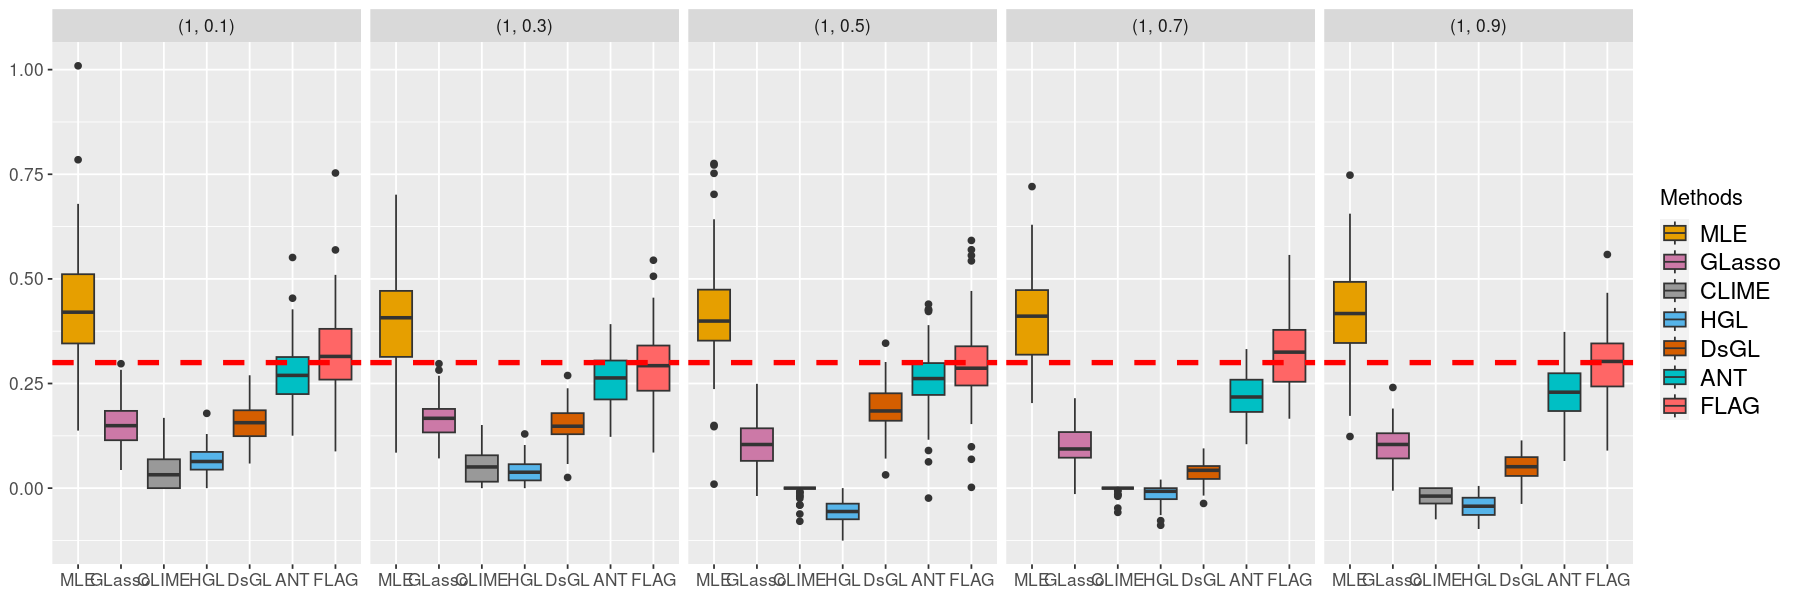

In [14]:
methods_order = c("MLE", "GLasso", "CLIME", "HGL", "DsGL", "ANT", "BGGM", "FLAG")
# estimation
est12 = reshape2::melt(res12[, methods_order])
est12$pair=("(1, 0.9)")
est34 = reshape2::melt(res34[, methods_order])
est34$pair=("(1, 0.7)")
est56 = reshape2::melt(res56[, methods_order])
est56$pair=("(1, 0.5)")
est78 = reshape2::melt(res78[, methods_order])
est78$pair=("(1, 0.3)")
est90 = reshape2::melt(res90[, methods_order])
est90$pair=("(1, 0.1)")
est = rbind(est12, est34, est56, est78, est90)
colnames(est)[2]='Methods' # rename 'Var2' as 'Methods'

options(repr.plot.width=15, repr.plot.height=5)
ggplot(subset(est, Methods %in% c("MLE", "GLasso", "CLIME", "HGL", "DsGL", "ANT", "FLAG")), aes(x = Methods, y=value, fill = Methods)) +
  scale_fill_manual(values=c("#E69F00", "#CC79A7", "#999999", "#56B4E9", "#D55E00", "#00BFC4", "#FF6666")) +
  geom_boxplot() + geom_hline(yintercept = theta, lty = "dashed", color='red', size=1.5) + facet_wrap(.~pair, nrow=1) +
  xlab(NULL)+ylab(NULL) + theme(text = element_text(size = 13), legend.text = element_text(size = 14))

In [6]:
colMeans(err)
colMeans(err.2hub)
colMeans(err.1hub)
colMeans(err.block)

MLE     CLIME  FLAG.fdr   ANT.fdr      BGGM    GLasso       HGL      DsGL 
0.7722797 0.2860290 0.3285944 0.3335410 1.0669176 0.5042690 0.6644281 0.4122281

MLE      CLIME   FLAG.fdr    ANT.fdr       BGGM     GLasso        HGL 
 0.4918316  0.6055489  0.1600451  0.1814024 59.2196880  0.3199886  0.5486378 
      DsGL 
 0.4522873

MLE     CLIME  FLAG.fdr   ANT.fdr      BGGM    GLasso       HGL      DsGL 
1.1289026 1.0000000 0.8465128 0.7580095 5.2991488 0.6095816 0.9273744 0.6617657

MLE     CLIME  FLAG.fdr   ANT.fdr      BGGM    GLasso       HGL      DsGL 
0.7705295 0.2794768 0.3248686 0.3307535 0.8193867 0.5038173 0.6631769 0.4109187

In [7]:
sapply(err, function(x)sd(x)/sqrt(length(x)))
sapply(err.2hub, function(x)sd(x)/sqrt(length(x)))
sapply(err.1hub, function(x)sd(x)/sqrt(length(x)))
sapply(err.block, function(x)sd(x)/sqrt(length(x)))
       

MLE        CLIME     FLAG.fdr      ANT.fdr         BGGM       GLasso 
0.0048949113 0.0005358806 0.0013384819 0.0011821194 0.0052010637 0.0070233927 
         HGL         DsGL 
0.0003461740 0.0008045647

MLE       CLIME    FLAG.fdr     ANT.fdr        BGGM      GLasso 
0.007392465 0.001295731 0.004159898 0.003866250 0.696804462 0.005786888 
        HGL        DsGL 
0.001099954 0.001833093

MLE        CLIME     FLAG.fdr      ANT.fdr         BGGM       GLasso 
0.0094767619 0.0000000000 0.0026625865 0.0026336321 0.0740946343 0.0071768394 
         HGL         DsGL 
0.0007559817 0.0019352642

MLE        CLIME     FLAG.fdr      ANT.fdr         BGGM       GLasso 
0.0048908161 0.0005506708 0.0013566307 0.0011945239 0.0006632032 0.0070236668 
         HGL         DsGL 
0.0003453676 0.0008071070

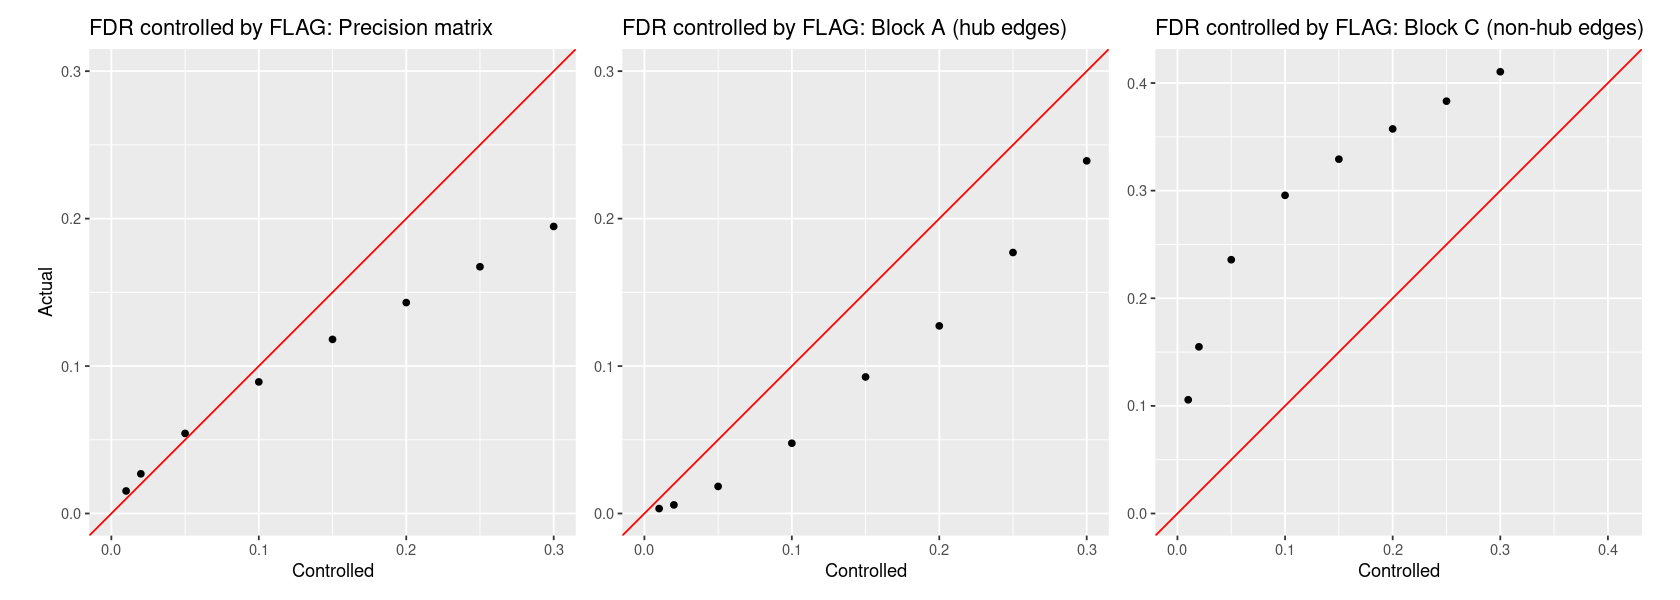

In [8]:
fdr.means = colMeans(fdr)
fdr.om = c(fdr.means['om.01'], fdr.means['om.02'], fdr.means['om.05'], fdr.means['om.1'], fdr.means['om.15'], fdr.means['om.2'], fdr.means['om.25'], fdr.means['om.3'])
p1=ggplot(data.frame(X=fdr.list, Y = fdr.om), aes(x=X, y=Y)) + geom_point() + 
  geom_abline(intercept = 0, slope = 1, color='red')+ coord_fixed() +
  scale_x_continuous(limits=c(0, 0.3))+scale_y_continuous(limits=c(0, 0.3))+
  ggtitle('FDR controlled by FLAG: Precision matrix')+xlab('Controlled')+ylab('Actual')
fdr.means = colMeans(fdr.2hub)
fdr.om = c(fdr.means['om.01'], fdr.means['om.02'], fdr.means['om.05'], fdr.means['om.1'], fdr.means['om.15'], fdr.means['om.2'], fdr.means['om.25'], fdr.means['om.3'])
p2=ggplot(data.frame(X=fdr.list, Y = fdr.om), aes(x=X, y=Y)) + geom_point() + 
  geom_abline(intercept = 0, slope = 1, color='red')+ coord_fixed() +
  scale_x_continuous(limits=c(0, 0.3))+scale_y_continuous(limits=c(0, 0.3))+
  ggtitle('FDR controlled by FLAG: Block A (hub edges)')+xlab('Controlled')+ylab(NULL)
fdr.means = colMeans(fdr.block)
fdr.om = c(fdr.means['om.01'], fdr.means['om.02'], fdr.means['om.05'], fdr.means['om.1'], fdr.means['om.15'], fdr.means['om.2'], fdr.means['om.25'], fdr.means['om.3'])
p3=ggplot(data.frame(X=fdr.list, Y = fdr.om), aes(x=X, y=Y)) + geom_point() + 
  geom_abline(intercept = 0, slope = 1, color='red')+ coord_fixed() +
  scale_x_continuous(limits=c(0, 0.411))+scale_y_continuous(limits=c(0, 0.411))+
  ggtitle('FDR controlled by FLAG: Block C (non-hub edges)')+xlab('Controlled')+ylab(NULL)
options(repr.plot.width=14, repr.plot.height=5)
p1+p2+p3

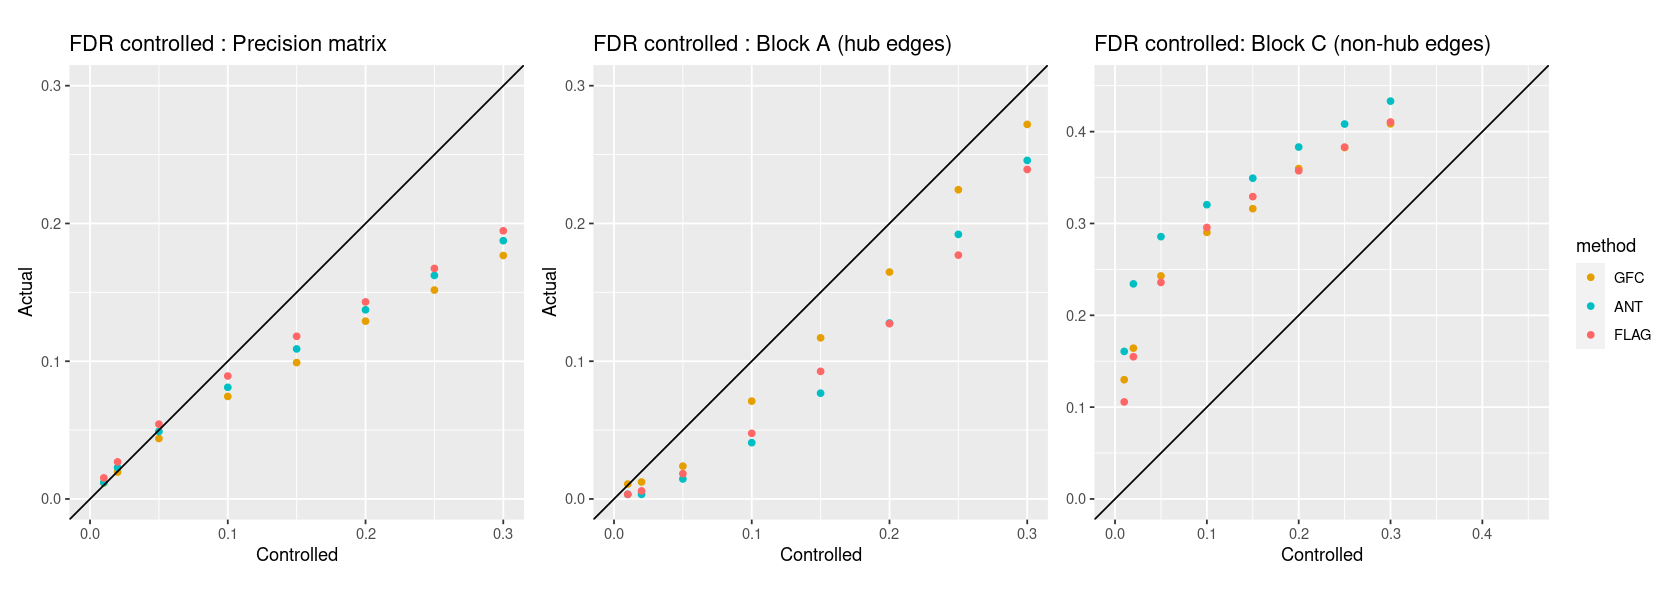

In [12]:
fdr.means = colMeans(fdr)
fdr.om = c(fdr.means['om.01'], fdr.means['om.02'], fdr.means['om.05'], fdr.means['om.1'], fdr.means['om.15'], fdr.means['om.2'], fdr.means['om.25'], fdr.means['om.3'])
fdr.ant = c(fdr.means['ant.01'], fdr.means['ant.02'], fdr.means['ant.05'], fdr.means['ant.1'], fdr.means['ant.15'], fdr.means['ant.2'], fdr.means['ant.25'], fdr.means['ant.3'])
fdr.gfc = c(fdr.means['gfc.01'], fdr.means['gfc.02'], fdr.means['gfc.05'], fdr.means['gfc.1'], fdr.means['gfc.15'], fdr.means['gfc.2'], fdr.means['gfc.25'], fdr.means['gfc.3'])
df = data.frame(X=c(fdr.list, fdr.list, fdr.list), Y = c(fdr.gfc, fdr.ant, fdr.om), 
                  method=c(rep('GFC', fdr.len), rep('ANT', fdr.len), rep('FLAG', fdr.len)))
df$method = factor(df$method, levels=c('GFC', 'ANT', 'FLAG'))
p1=ggplot(df, aes(x=X, y=Y, color=method)) +
  geom_point() + geom_abline(intercept = 0, slope = 1, color='black')+ coord_fixed() +
  scale_x_continuous(limits=c(0, 0.3))+scale_y_continuous(limits=c(0, 0.3))+ scale_color_manual(values=c("#E69F00", "#00BFC4", "#FF6666")) +
  ggtitle('FDR controlled : Precision matrix')+xlab('Controlled')+ylab('Actual')

fdr.means = colMeans(fdr.2hub)
fdr.om = c(fdr.means['om.01'], fdr.means['om.02'], fdr.means['om.05'], fdr.means['om.1'], fdr.means['om.15'], fdr.means['om.2'], fdr.means['om.25'], fdr.means['om.3'])
fdr.ant = c(fdr.means['ant.01'], fdr.means['ant.02'], fdr.means['ant.05'], fdr.means['ant.1'], fdr.means['ant.15'], fdr.means['ant.2'], fdr.means['ant.25'], fdr.means['ant.3'])
fdr.gfc = c(fdr.means['gfc.01'], fdr.means['gfc.02'], fdr.means['gfc.05'], fdr.means['gfc.1'], fdr.means['gfc.15'], fdr.means['gfc.2'], fdr.means['gfc.25'], fdr.means['gfc.3'])
df = data.frame(X=c(fdr.list, fdr.list, fdr.list), Y = c(fdr.gfc, fdr.ant, fdr.om), 
                  method=c(rep('GFC', fdr.len), rep('ANT', fdr.len), rep('FLAG', fdr.len)))
df$method = factor(df$method, levels=c('GFC', 'ANT', 'FLAG'))
p2=ggplot(df, aes(x=X, y=Y, color=method)) +
  geom_point() + geom_abline(intercept = 0, slope = 1, color='black')+ coord_fixed() +
  scale_x_continuous(limits=c(0, 0.3))+scale_y_continuous(limits=c(0, 0.3))+ scale_color_manual(values=c("#E69F00", "#00BFC4", "#FF6666")) +
  ggtitle('FDR controlled : Block A (hub edges)')+xlab('Controlled')+ylab('Actual')

fdr.means = colMeans(fdr.block)
fdr.om = c(fdr.means['om.01'], fdr.means['om.02'], fdr.means['om.05'], fdr.means['om.1'], fdr.means['om.15'], fdr.means['om.2'], fdr.means['om.25'], fdr.means['om.3'])
fdr.ant = c(fdr.means['ant.01'], fdr.means['ant.02'], fdr.means['ant.05'], fdr.means['ant.1'], fdr.means['ant.15'], fdr.means['ant.2'], fdr.means['ant.25'], fdr.means['ant.3'])
fdr.gfc = c(fdr.means['gfc.01'], fdr.means['gfc.02'], fdr.means['gfc.05'], fdr.means['gfc.1'], fdr.means['gfc.15'], fdr.means['gfc.2'], fdr.means['gfc.25'], fdr.means['gfc.3'])
df = data.frame(X=c(fdr.list, fdr.list, fdr.list), Y = c(fdr.gfc, fdr.ant, fdr.om), 
                  method=c(rep('GFC', fdr.len), rep('ANT', fdr.len), rep('FLAG', fdr.len)))
df$method = factor(df$method, levels=c('GFC', 'ANT', 'FLAG'))
p3=ggplot(df, aes(x=X, y=Y, color=method)) +
  geom_point() + geom_abline(intercept = 0, slope = 1, color='black')+ coord_fixed() +
  scale_x_continuous(limits=c(0, 0.45))+scale_y_continuous(limits=c(0, 0.45))+ scale_color_manual(values=c("#E69F00", "#00BFC4", "#FF6666")) +
  ggtitle('FDR controlled: Block C (non-hub edges)')+xlab('Controlled')+ylab(NULL)
options(repr.plot.width=14, repr.plot.height=5)
p1+p2+p3+ plot_layout(guides = "collect")

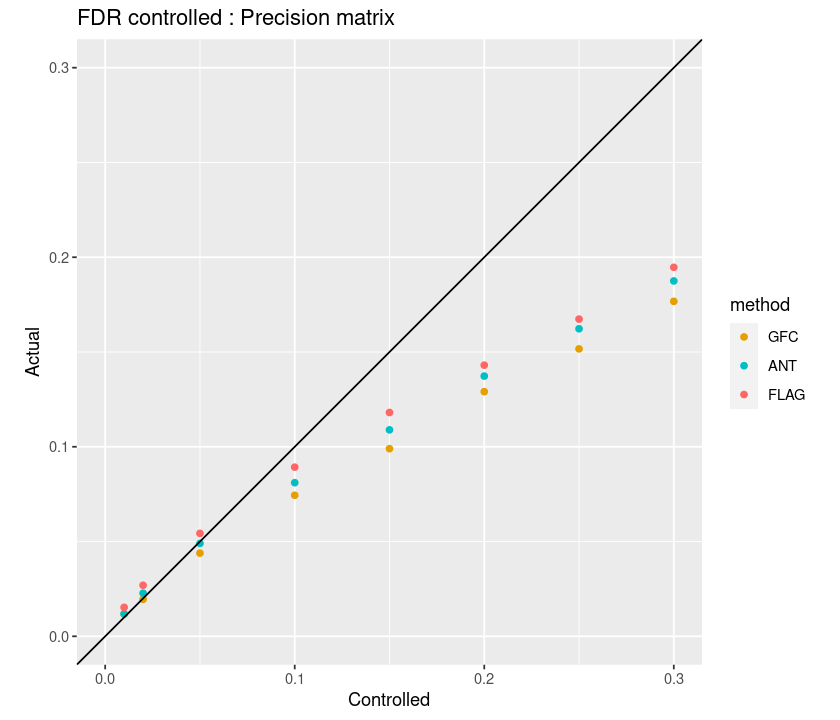

In [13]:
fdr.means = colMeans(fdr)
fdr.om = c(fdr.means['om.01'], fdr.means['om.02'], fdr.means['om.05'], fdr.means['om.1'], fdr.means['om.15'], fdr.means['om.2'], fdr.means['om.25'], fdr.means['om.3'])
fdr.ant = c(fdr.means['ant.01'], fdr.means['ant.02'], fdr.means['ant.05'], fdr.means['ant.1'], fdr.means['ant.15'], fdr.means['ant.2'], fdr.means['ant.25'], fdr.means['ant.3'])
fdr.gfc = c(fdr.means['gfc.01'], fdr.means['gfc.02'], fdr.means['gfc.05'], fdr.means['gfc.1'], fdr.means['gfc.15'], fdr.means['gfc.2'], fdr.means['gfc.25'], fdr.means['gfc.3'])
df = data.frame(X=c(fdr.list, fdr.list, fdr.list), Y = c(fdr.gfc, fdr.ant, fdr.om), 
                  method=c(rep('GFC', fdr.len), rep('ANT', fdr.len), rep('FLAG', fdr.len)))
df$method = factor(df$method, levels=c('GFC', 'ANT', 'FLAG'))
options(repr.plot.width=7, repr.plot.height=6)
ggplot(df, aes(x=X, y=Y, color=method)) +
  geom_point() + geom_abline(intercept = 0, slope = 1, color='black')+ coord_fixed() +
  scale_x_continuous(limits=c(0, 0.3))+scale_y_continuous(limits=c(0, 0.3))+ scale_color_manual(values=c("#E69F00", "#00BFC4", "#FF6666")) +
  ggtitle('FDR controlled : Precision matrix')+xlab('Controlled')+ylab('Actual')

In [10]:
# edges within hubs
roc.hub = list()
res.true = rep(get.tri( get.2hub(Pre.adj, m)), rep.times)
roc.hub$MLE=roc(response=res.true, predictor=abs(MLE.2hub.list), direction = "<")
roc.hub$GLASSO=roc(response=res.true, predictor=abs(GLASSO.2hub.list), direction = "<")
roc.hub$CLIME=roc(response=res.true, predictor=abs(CLIME.2hub.list), direction = "<")
roc.hub$HGL=roc(response=res.true, predictor=abs(HGL.2hub.list), direction = "<")
roc.hub$DSGL=roc(response=res.true, predictor=abs(DSGL.2hub.list), direction = "<")
roc.hub$ANT=roc(response=res.true, predictor=abs(ANT.2hub.list), direction = "<")
roc.hub$BGGM=roc(response=res.true, predictor=abs(BGGM.2hub.list), direction = "<")
roc.hub$FLAG=roc(response=res.true, predictor=abs(OM.2hub.list), direction = "<")
# block
roc.block = list()
res.true = rep(get.tri( get.block(Pre.adj, m, m+pblock)), rep.times)
roc.block$MLE=roc(response=res.true, predictor=abs(MLE.block.list), direction = "<")
roc.block$GLASSO=roc(response=res.true, predictor=abs(GLASSO.block.list), direction = "<")
roc.block$CLIME=roc(response=res.true, predictor=abs(CLIME.block.list), direction = "<")
roc.block$HGL=roc(response=res.true, predictor=abs(HGL.block.list), direction = "<")
roc.block$DSGL=roc(response=res.true, predictor=abs(DSGL.block.list), direction = "<")
roc.block$ANT=roc(response=res.true, predictor=abs(ANT.block.list), direction = "<")
roc.block$BGGM=roc(response=res.true, predictor=abs(BGGM.block.list), direction = "<")
roc.block$FLAG=roc(response=res.true, predictor=abs(OM.block.list), direction = "<")

Setting levels: control = 0, case = 1

Setting levels: control = 0, case = 1

Setting levels: control = 0, case = 1

Setting levels: control = 0, case = 1

Setting levels: control = 0, case = 1

Setting levels: control = 0, case = 1

Setting levels: control = 0, case = 1

Setting levels: control = 0, case = 1

Setting levels: control = 0, case = 1

Setting levels: control = 0, case = 1

Setting levels: control = 0, case = 1

Setting levels: control = 0, case = 1

Setting levels: control = 0, case = 1

Setting levels: control = 0, case = 1

Setting levels: control = 0, case = 1

Setting levels: control = 0, case = 1



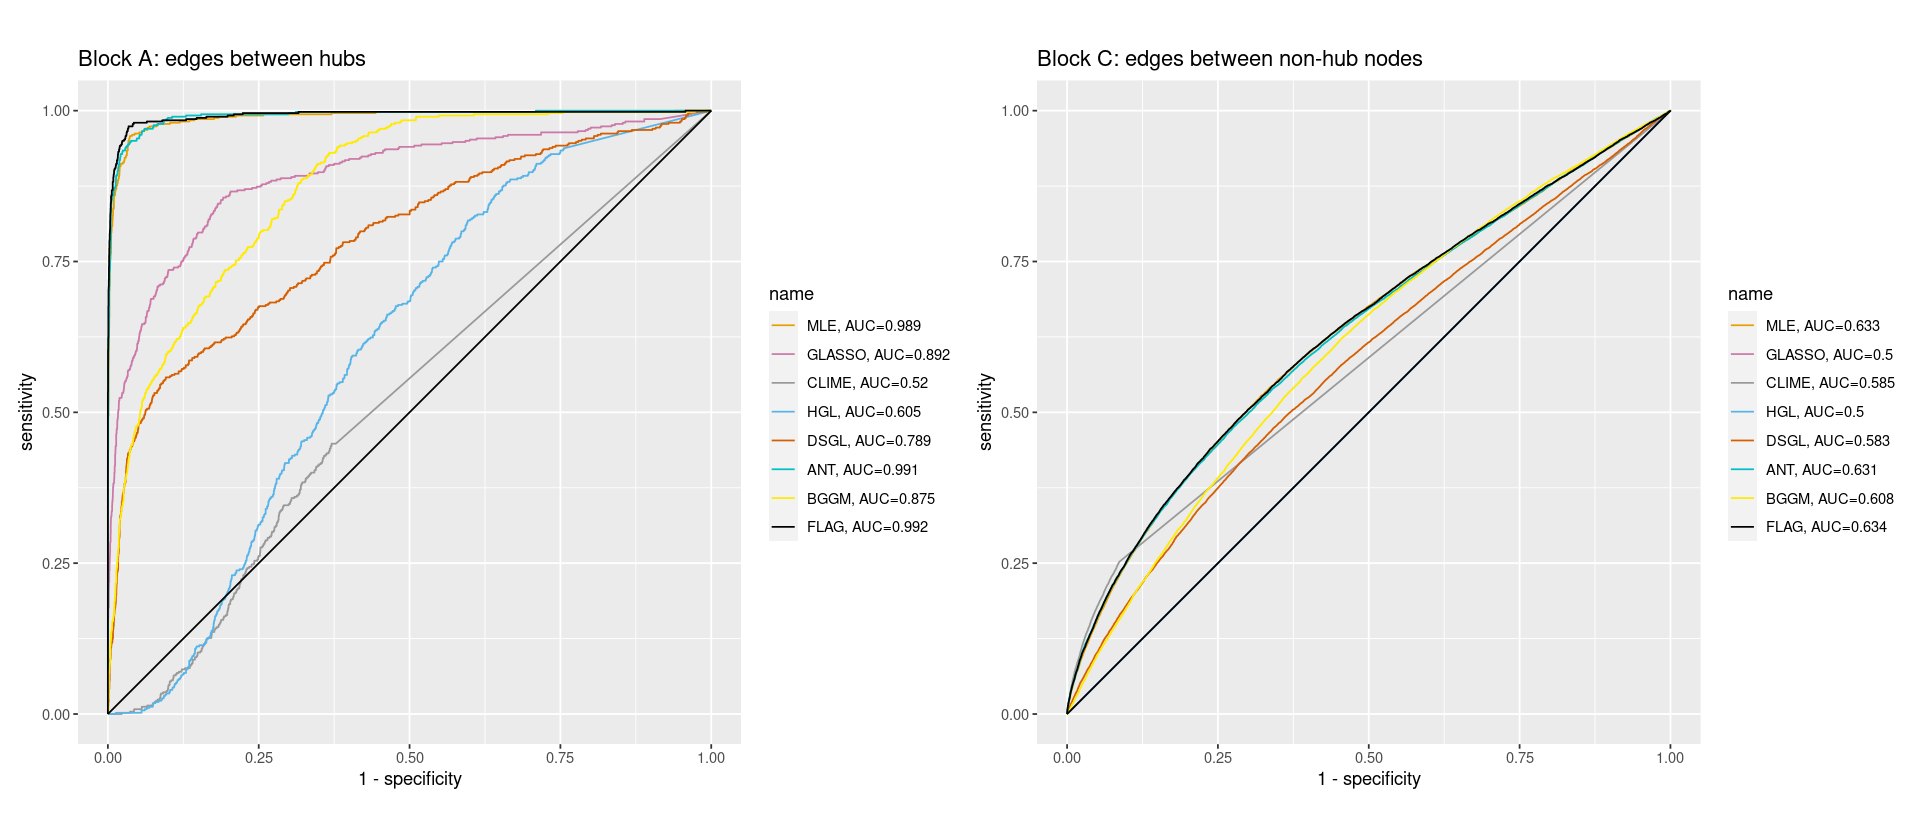

In [11]:
methods_color = c("#E69F00", "#CC79A7", "#999999", "#56B4E9", "#D55E00", "#00BFC4", "#FFEA00", "#000000")

options(repr.plot.width=16, repr.plot.height=7)
ggroc(roc.hub, legacy.axes=TRUE)+ annotate(geom='segment', x=0, y=0, xend=1, yend=1) +
  scale_colour_manual(labels=get.roc.labels(roc.hub,digits=3),values = methods_color)+
  ggtitle('Block A: edges between hubs')+ coord_fixed() +
ggroc(roc.block, legacy.axes=TRUE)+ annotate(geom='segment', x=0, y=0, xend=1, yend=1) +
  scale_colour_manual(labels=get.roc.labels(roc.block,digits=3),values = methods_color)+
  ggtitle('Block C: edges between non-hub nodes')+ coord_fixed()